In [292]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.api.types import is_float_dtype
warnings.filterwarnings('ignore')

In [293]:

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [294]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

class ParkingComplaintPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.model = None
        self.feature_names = []
        self.log_target = False

    def load_data(self, parking_file: str, complaint_file: str):
        """
        Load parking and complaint CSVs into DataFrames.
        """
        self.parking_df = pd.read_csv(parking_file)
        self.complaint_df = pd.read_csv(complaint_file)
        print(f"Loaded parking data: {len(self.parking_df)} rows")
        print(f"Loaded complaint data: {len(self.complaint_df)} rows")

    def preprocess_features(self):
        """
        Only select numeric features. 
        Fee/categorical are encoded later in split_data.
        """
        df = self.parking_df
        numeric = ['총주차면', '1시간 요금', '평일운영시간', '토요일운영시간', '공휴일운영시간', 'cctv_r300', 'bus_r300']
        categorical = ['주차장종류', '운영구분']
        fee = ['평일유료', '토요일유료', '공휴일유료']

        self.numeric_features = [c for c in numeric if c in df]
        self.categorical_features = [c for c in categorical if c in df]
        self.fee_features = [c for c in fee if c in df]

        # 최종 feature_names는 numeric + fee + categorical
        self.feature_names = self.numeric_features + self.fee_features + self.categorical_features
        print(f"Selected features (no encoding yet): {self.feature_names}")

    def log_transform_target(self, target: str = 'complaints_r300') -> None:
        """
        Apply log1p transformation to the target column.
        """
        if target in self.parking_df.columns:
            self.parking_df[target] = np.log1p(self.parking_df[target])
            self.log_target = True
            print(f"Applied log1p to {target}")
        else:
            raise KeyError(f"Target column '{target}' not found.")

    def inverse_log(self, arr: np.ndarray) -> np.ndarray:
        """
        Inverse of log1p if log_target is True, otherwise return input.
        """
        return np.expm1(arr) if self.log_target else arr

    def exploratory_data_analysis(self, target: str = 'complaints_r300') -> None:
        """
        For target & each numeric feature, plot distribution before/after log1p
        if skewness > 2 (otherwise only original).
        """
        # --- Target ---
        y = self.parking_df[target].dropna()
        sk_y = y.skew()
        plt.figure()
        plt.hist(y, bins=30, alpha=0.6)
        plt.title(f'Target Original (skew={sk_y:.2f})')
        plt.show()
        if sk_y > 2:
            y_log = np.log1p(y)
            sk_y_log = y_log.skew()
            plt.figure()
            plt.hist(y_log, bins=30, alpha=0.6)
            plt.title(f'Target log1p (skew={sk_y_log:.2f})')
            plt.show()
        
        # --- Features ---
        for c in self.feature_names:
            if pd.api.types.is_numeric_dtype(self.parking_df[c]):
                x = self.parking_df[c].dropna()
                sk_x = x.skew()
                plt.figure()
                sns.histplot(x, kde=True)
                plt.title(f"{c} Original (skew={sk_x:.2f})")
                plt.show()
                if sk_x > 2:
                    x_log = np.log1p(x)
                    sk_x_log = x_log.skew()
                    plt.figure()
                    sns.histplot(x_log, kde=True)
                    plt.title(f"{c} log1p (skew={sk_x_log:.2f})")
                    plt.show()

    def check_linearity(self, target: str = 'complaints_r300') -> None:
        """
        For each numeric feature:
        - Plot x(original) vs y(original)
        - If x skew > 2 and x>0, plot log1p(x) vs log1p(y) (if y skew>2 and y>0),
            else log1p(x) vs log1p(y) (if y>0), 
            else log1p(x) vs y(original)
        - If x skew <= 2, plot x(original) vs log1p(y) (if y skew>2 and y>0)
        """
        y = self.parking_df[target]
        sk_y = y.skew()
        log_target_possible = sk_y > 2
        y_log = np.log1p(y) 

        for c in self.feature_names:
            if pd.api.types.is_numeric_dtype(self.parking_df[c]):
                x = self.parking_df[c]
                sk_x = x.skew()
                plt.figure(figsize=(10, 4))
                # (1) 원본 vs 원본
                plt.subplot(1, 2, 1)
                sns.regplot(x=x, y=y, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
                plt.title(f"{c} (skew={sk_x:.2f}) vs {target} (original, skew={sk_y:.2f})")
                
                # (2) 로그변환 관계
                plt.subplot(1, 2, 2)
                # 설명변수 skew > 2, 양수
                if sk_x > 2:
                    x_log = np.log1p(x)
                    # 타깃도 skew > 2 & 양수면 log-log
                    if log_target_possible:
                        sns.regplot(x=x_log, y=y_log, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
                        plt.title(f"log1p({c}) vs log1p({target})")
                    else:
                        sns.regplot(x=x_log, y=y, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
                        plt.title(f"log1p({c}) vs {target} (original)")
                # 설명변수 skew ≤ 2, 타깃만 로그변환
                elif log_target_possible:
                    sns.regplot(x=x, y=y_log, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
                    plt.title(f"{c} vs log1p({target})")
                else:
                    # 특별한 로그 변환 없음 (subplot 공간 맞추기)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()

    def linearity_r2_scores(self, target: str = 'complaints_r300') -> pd.DataFrame:
        """
        각 numeric feature별로
        - 원본 vs 원본
        - log1p(x) vs 원본
        - 원본 vs log1p(y)
        - log1p(x) vs log1p(y)
        R²를 모두 계산한 뒤, skew 기준으로 적절한 R²(최적 조합)도 별도 반환.
        """
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import r2_score
        import numpy as np
        import pandas as pd

        df = self.parking_df
        y_orig = df[target]
        y_log = np.log1p(y_orig)
        sk_y = y_orig.skew()
        log_target_possible = sk_y > 2

        results = []
        full_table = []

        for c in self.feature_names:
            if pd.api.types.is_numeric_dtype(df[c]):
                x_orig = df[c]
                x_log = np.log1p(x_orig)
                sk_x = x_orig.skew()
                log_feat_possible = sk_x > 2

                # 각 조합별 R²
                combos = [
                    ('orig', 'orig', x_orig, y_orig),
                    ('logx', 'orig', x_log, y_orig),
                    ('orig', 'logy', x_orig, y_log),
                    ('logx', 'logy', x_log, y_log),
                ]
                r2s = {}
                for lx, ly, xx, yy in combos:
                    valid = (~np.isnan(xx)) & (~np.isnan(yy))
                    if valid.sum() > 1:
                        m = LinearRegression().fit(xx[valid].values.reshape(-1, 1), yy[valid].values)
                        r2s[f'{lx}_{ly}'] = r2_score(yy[valid], m.predict(xx[valid].values.reshape(-1, 1)))
                    else:
                        r2s[f'{lx}_{ly}'] = np.nan

                # skew 기준: check_linearity의 규칙 반영
                if log_feat_possible and log_target_possible:
                    best = 'logx_logy'
                elif log_feat_possible:
                    best = 'logx_orig'
                elif log_target_possible:
                    best = 'orig_logy'
                else:
                    best = 'orig_orig'

                results.append({
                    'feature': c,
                    'skew_x': sk_x,
                    'skew_y': sk_y,
                    'R2_best': r2s[best],
                    'best_combo': best,
                    'R2_orig_orig': r2s['orig_orig'],
                    'R2_logx_orig': r2s['logx_orig'],
                    'R2_orig_logy': r2s['orig_logy'],
                    'R2_logx_logy': r2s['logx_logy']
                })

                # 모든 조합 표 (원하면 반환용)
                full_table.append([c, sk_x, r2s['orig_orig'], r2s['logx_orig'], r2s['orig_logy'], r2s['logx_logy']])

        result_df = pd.DataFrame(results).sort_values('R2_best', ascending=False).reset_index(drop=True)
        print(result_df[['feature', 'skew_x', 'skew_y', 'R2_best', 'best_combo']].round(3))
        return result_df


    def split_data(self, target: str = 'complaints_r300', test_size: float = 0.1, val_size: float = 0.2):
        """
        Split, then label-encode fee & categorical features.
        """
        df = self.parking_df.copy()
        X = df[self.feature_names].copy()
        y = df[target]

        # 인코딩 (fee + categorical)
        for col in self.fee_features + self.categorical_features:
            if col in X:
                le = LabelEncoder()
                X[col] = X[col].fillna('Unknown')
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le
        print(df.head())
        # 나머지는 동일
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=self.random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=self.random_state)
        self.X_train = self.scaler.fit_transform(X_train)
        self.X_val   = self.scaler.transform(X_val)
        self.X_test  = self.scaler.transform(X_test)
        self.y_train = y_train; self.y_val = y_val; self.y_test = y_test
        print(f"Split: train={len(self.y_train)}, val={len(self.y_val)}, test={len(self.y_test)}")


    def train_model(self):
        """
        Fit a LinearRegression model on training data.
        """
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        print("Model trained.")

    def evaluate_model(self) -> dict:
        """
        Evaluate the trained model on test data.
        """
        y_pred = self.model.predict(self.X_test)
        if self.log_target:
            y_pred = self.inverse_log(y_pred)
            y_true = self.inverse_log(self.y_test.values)
        else:
            y_true = self.y_test.values
        metrics = {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'EVS': explained_variance_score(y_true, y_pred)
        }
        print(metrics)
        return metrics

    def analyze_coefficients(self, top_n: int = 15) -> pd.Series:
        """
        Return top_n features by absolute coefficient magnitude.
        """
        coefs = pd.Series(self.model.coef_, index=self.feature_names)
        top = coefs.abs().sort_values(ascending=False).head(top_n)
        print(top)
        return top


In [295]:
predictor = ParkingComplaintPredictor()

In [296]:
predictor.load_data('src/parks_addGroupedInfo.csv', 'reports.csv')

Loaded parking data: 1405 rows
Loaded complaint data: 3064538 rows


In [297]:
# 특성 전처리
predictor.preprocess_features()

Selected features (no encoding yet): ['총주차면', '1시간 요금', '평일운영시간', '토요일운영시간', '공휴일운영시간', 'cctv_r300', 'bus_r300', '평일유료', '토요일유료', '공휴일유료', '주차장종류', '운영구분']


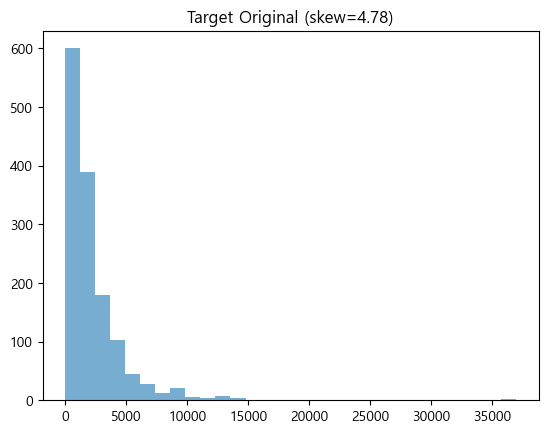

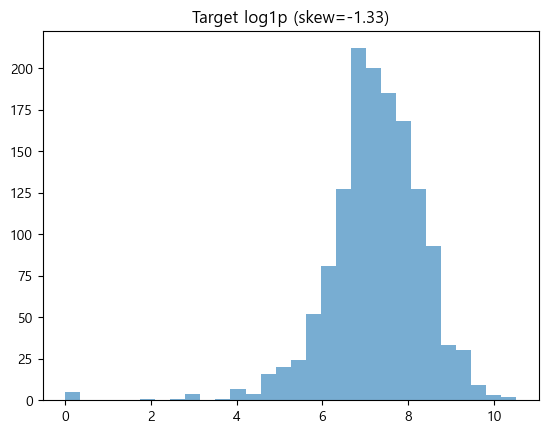

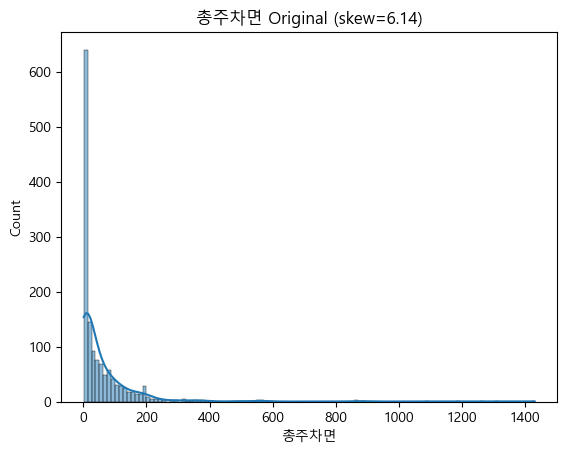

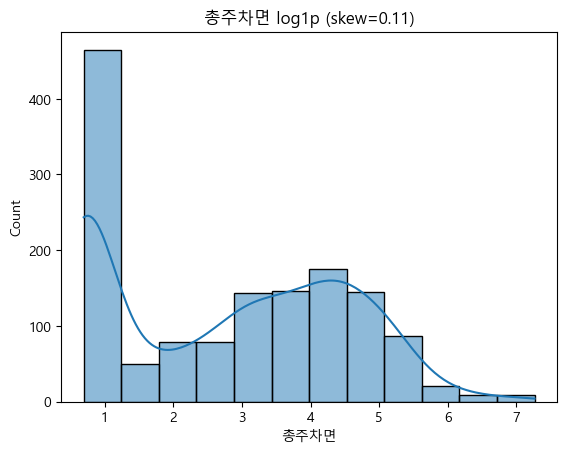

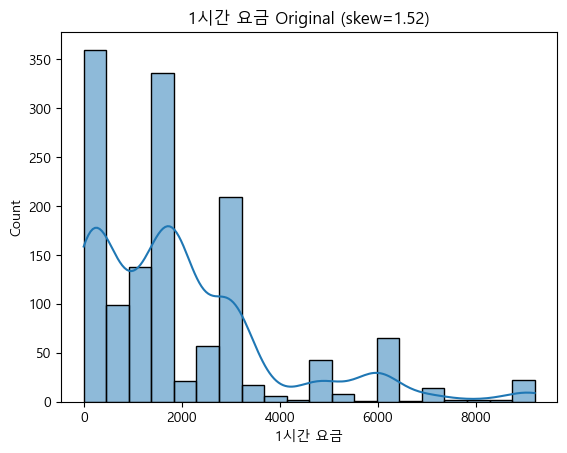

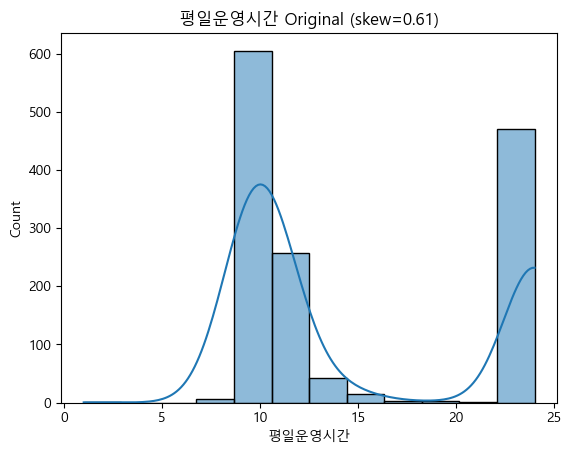

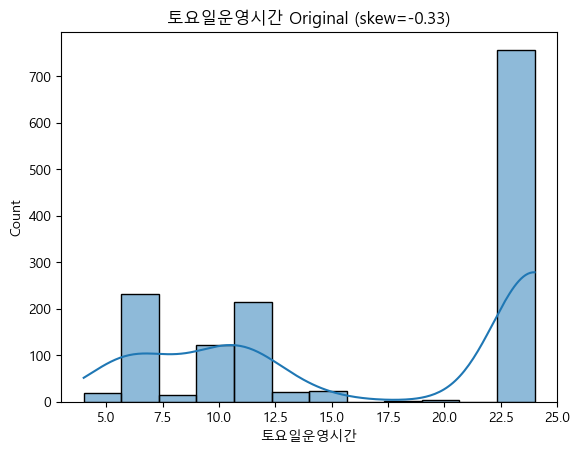

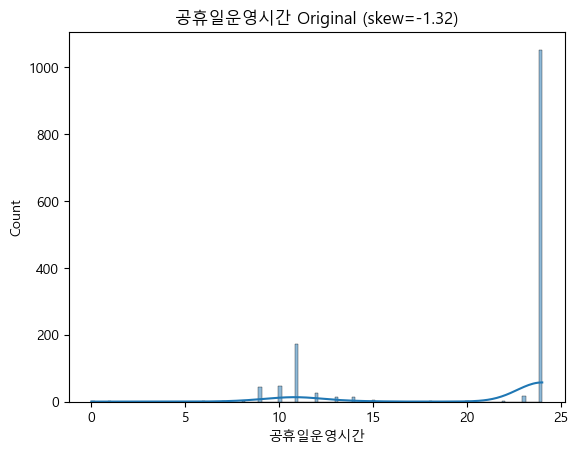

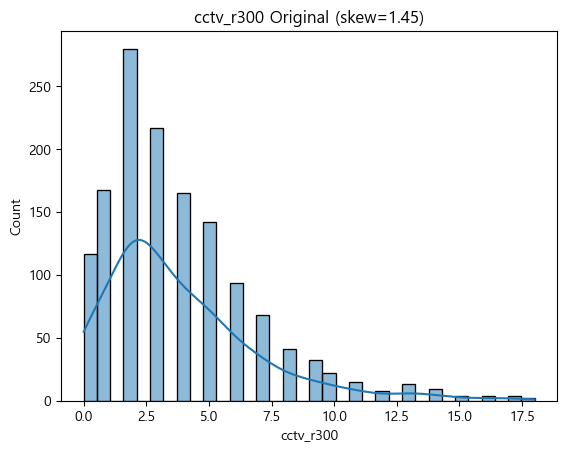

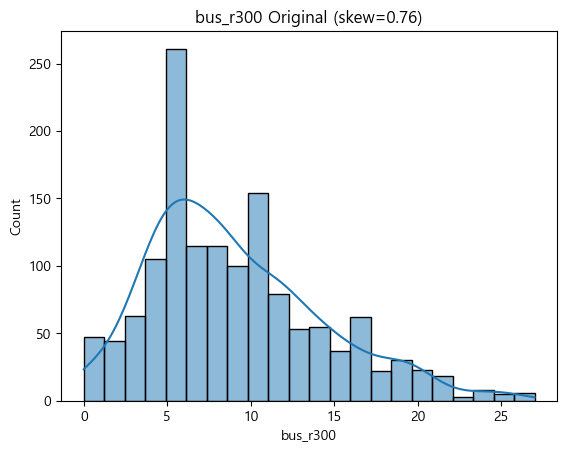

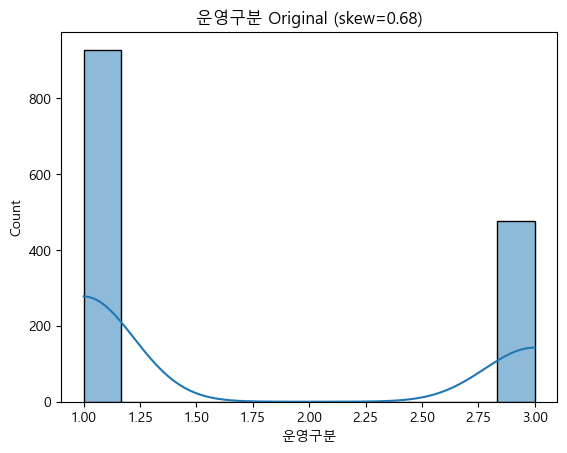

In [298]:
predictor.exploratory_data_analysis()

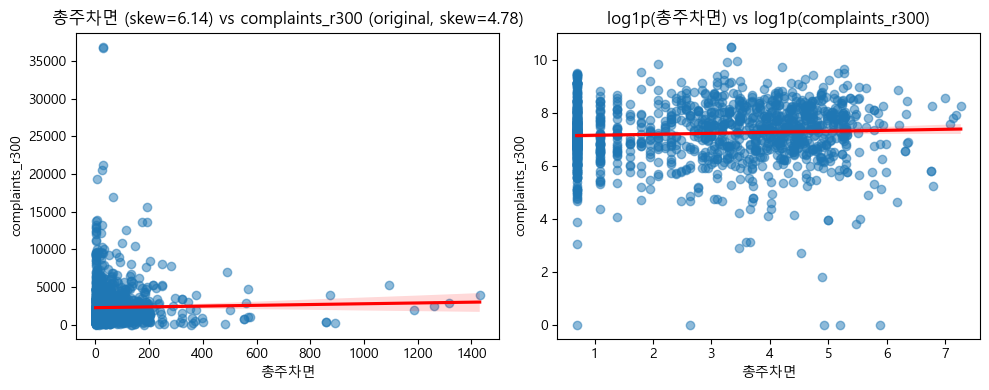

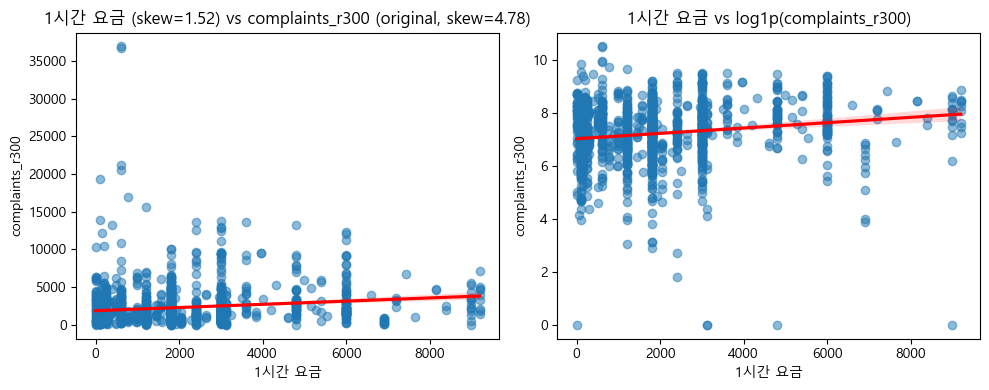

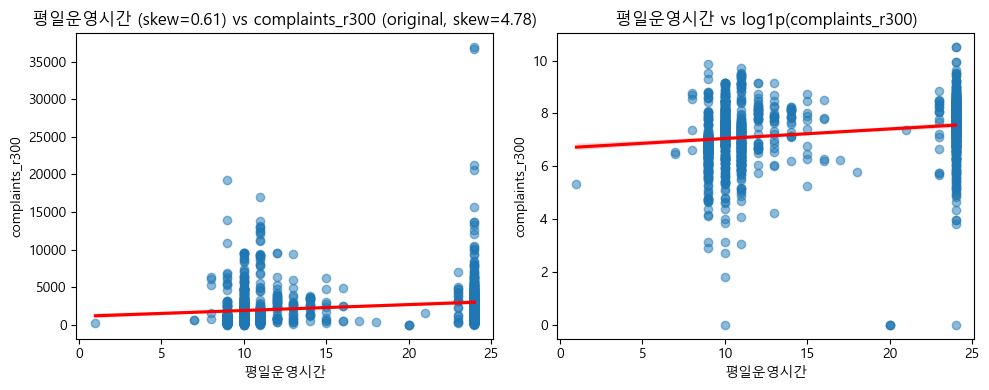

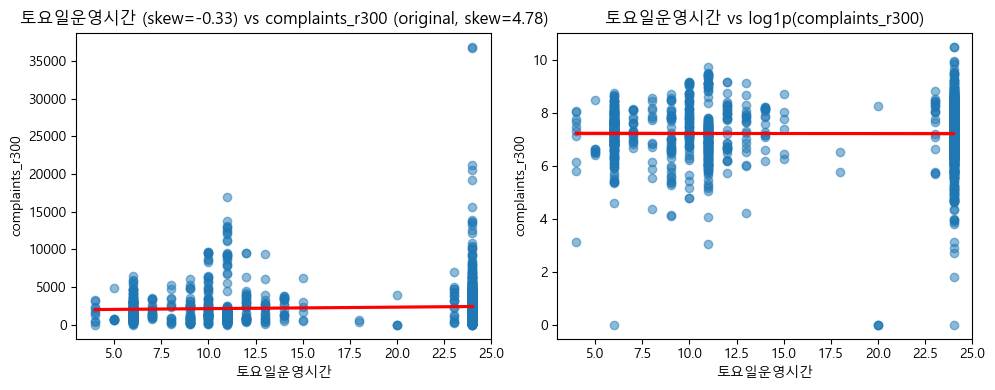

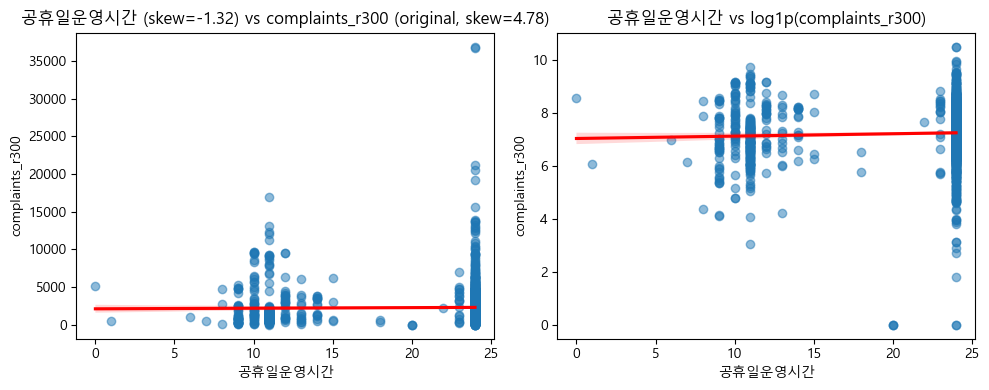

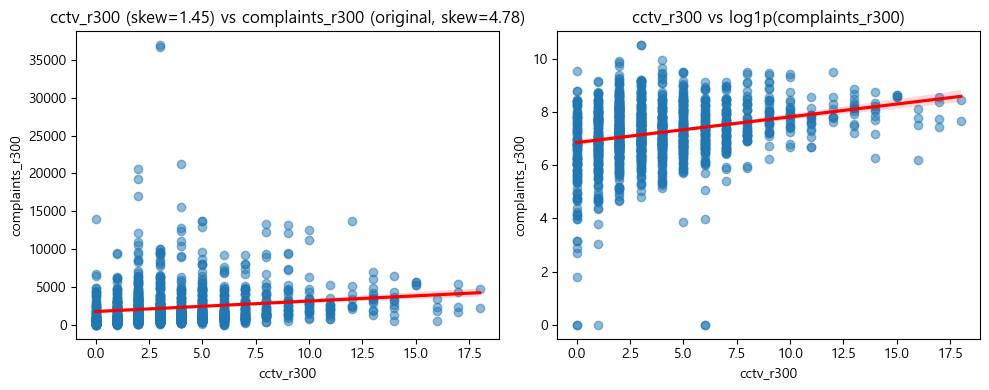

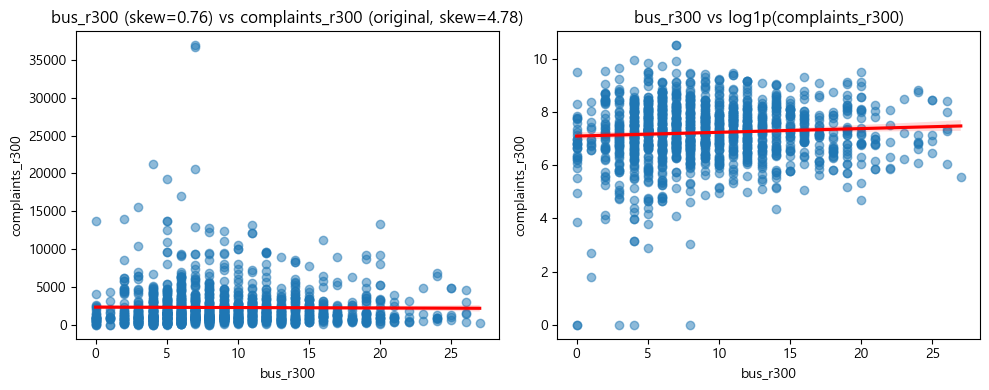

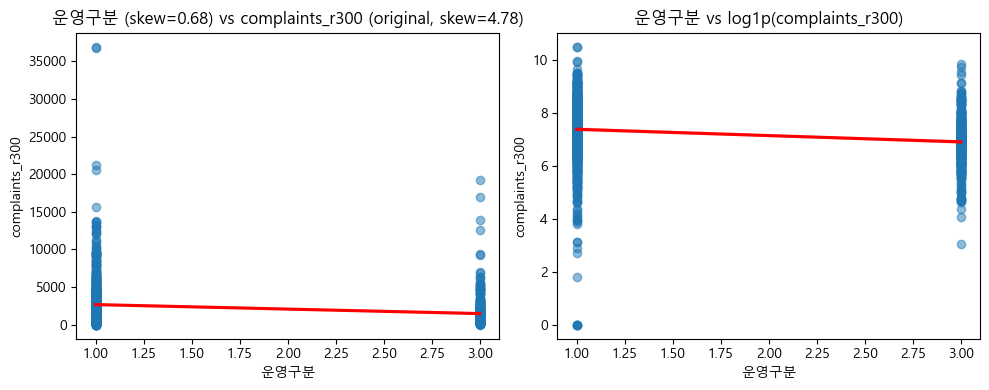

In [299]:
predictor.check_linearity()

In [300]:
predictor.linearity_r2_scores()

     feature  skew_x  skew_y  R2_best best_combo
0  cctv_r300   1.450   4.784    0.071  orig_logy
1     평일운영시간   0.608   4.784    0.045  orig_logy
2       운영구분   0.679   4.784    0.040  orig_logy
3     1시간 요금   1.525   4.784    0.029  orig_logy
4   bus_r300   0.757   4.784    0.004  orig_logy
5       총주차면   6.141   4.784    0.003  logx_logy
6    공휴일운영시간  -1.322   4.784    0.002  orig_logy
7    토요일운영시간  -0.325   4.784    0.000  orig_logy


,feature,skew_x,skew_y,R2_best,best_combo,R2_orig_orig,R2_logx_orig,R2_orig_logy,R2_logx_logy
0,cctv_r300,1.449646,4.784374,0.070820,orig_logy,0.024376,0.026548,0.070820,0.091684
1,평일운영시간,0.608146,4.784374,0.044950,orig_logy,0.035105,0.037053,0.044950,0.048257
2,운영구분,0.678590,4.784374,0.040348,orig_logy,0.042632,0.042632,0.040348,0.040348
3,1시간 요금,1.524946,4.784374,0.029111,orig_logy,0.021480,0.009365,0.029111,0.015793
4,bus_r300,0.757277,4.784374,0.004282,orig_logy,0.000114,0.000299,0.004282,0.013419
5,총주차면,6.141128,4.784374,0.003371,logx_logy,0.000472,0.003684,0.000243,0.003371
6,공휴일운영시간,-1.321748,4.784374,0.002013,orig_logy,0.000265,0.000194,0.002013,0.001704
7,토요일운영시간,-0.325307,4.784374,0.000010,orig_logy,0.003162,0.004149,0.000010,0.000004


In [301]:
predictor.split_data()

     주차장코드              주소 주차장종류  운영구분   총주차면 평일유료 토요일유료 공휴일유료  평일시작  평일종료  \
0   173389   강남구 개포동 126-2    NW     1  132.0    Y     Y     Y     9    19   
1  1040225  강남구 개포동 1266-0    NW     1   97.0    Y     N     N     0    24   
2  1033754  강남구 개포동 1273-0    NW     1  194.0    Y     N     N     0    24   
3   173472    강남구 개포동 13-2    NW     1  168.0    Y     N     N     0    24   
4   173468   강남구 개포동 183-2    NW     1  149.0    Y     N     N     0    24   

   ...  추가단위시간         lon        lat  평일운영시간  토요일운영시간  공휴일운영시간  1시간 요금  \
0  ...     5.0  127.066477  37.477263      10       24       24  2400.0   
1  ...     5.0  127.048218  37.481496      24       24       24  2400.0   
2  ...     5.0  127.052365  37.475646      24       24       24  2400.0   
3  ...     5.0  127.079307  37.494938      24       24       24  1200.0   
4  ...     5.0  127.066238  37.489490      24       24       24  2400.0   

   cctv_r300  bus_r300  complaints_r300  
0          0         1                

In [302]:
predictor.train_model()

Model trained.


In [303]:
predictor.evaluate_model()

{'MSE': 4146381.0613361294, 'RMSE': 2036.266451458681, 'MAE': 1252.2334134541293, 'R2': 0.2366775426404485, 'EVS': 0.2550497421800285}


{'MSE': 4146381.0613361294,
 'RMSE': 2036.266451458681,
 'MAE': 1252.2334134541293,
 'R2': 0.2366775426404485,
 'EVS': 0.2550497421800285}

In [304]:
predictor.analyze_coefficients()

평일운영시간       517.177709
운영구분         448.083225
cctv_r300    388.034669
총주차면         288.292304
1시간 요금       222.906733
공휴일운영시간      198.613131
토요일운영시간      147.452974
bus_r300      84.863330
토요일유료         78.199417
평일유료          32.148396
공휴일유료         31.162591
주차장종류         11.285011
dtype: float64


평일운영시간       517.177709
운영구분         448.083225
cctv_r300    388.034669
총주차면         288.292304
1시간 요금       222.906733
공휴일운영시간      198.613131
토요일운영시간      147.452974
bus_r300      84.863330
토요일유료         78.199417
평일유료          32.148396
공휴일유료         31.162591
주차장종류         11.285011
dtype: float64

In [305]:
%pip install jenkspy

Note: you may need to restart the kernel to use updated packages.


In [306]:
parks_df = pd.read_csv("src/parks_addGroupedInfo.csv")
parks_df.head()

,주차장코드,주소,주차장종류,운영구분,총주차면,평일유료,토요일유료,공휴일유료,평일시작,평일종료,...,추가단위시간,lon,lat,평일운영시간,토요일운영시간,공휴일운영시간,1시간 요금,cctv_r300,bus_r300,complaints_r300
0,173389,강남구 개포동 126-2,NW,1,132.0,Y,Y,Y,9,19,...,5.0,127.066477,37.477263,10,24,24,2400.0,0,1,5
1,1040225,강남구 개포동 1266-0,NW,1,97.0,Y,N,N,0,24,...,5.0,127.048218,37.481496,24,24,24,2400.0,0,1,1046
2,1033754,강남구 개포동 1273-0,NW,1,194.0,Y,N,N,0,24,...,5.0,127.052365,37.475646,24,24,24,2400.0,3,5,1492
3,173472,강남구 개포동 13-2,NW,1,168.0,Y,N,N,0,24,...,5.0,127.079307,37.494938,24,24,24,1200.0,2,4,1177
4,173468,강남구 개포동 183-2,NW,1,149.0,Y,N,N,0,24,...,5.0,127.066238,37.489490,24,24,24,2400.0,2,7,536


In [307]:
from jenkspy import JenksNaturalBreaks

i = 3

breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print(breaks.breaks_)  # 구간 경계

parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"], bins=breaks.breaks_, labels=range(i), include_lowest=True
)
parks_df["complaint_level"].value_counts()

[0, 2761, 8353, 36939]


complaint_level
0    1044
1     311
2      50
Name: count, dtype: int64

In [311]:
from sklearn.preprocessing import LabelEncoder

df = parks_df
numeric = ['총주차면', '1시간 요금', '평일운영시간', '토요일운영시간', '공휴일운영시간', 'cctv_r300', 'bus_r300']
categorical = ['주차장종류', '운영구분']

if '총주차면' in df:
    df['총주차면'] = np.log1p(df['총주차면'])
    
# Fee encoding
for col in ['평일유료', '토요일유료', '공휴일유료']:
    if col in df:
        df[f"{col}_encoded"] = (
            df[col].astype(str)
                    .str.lower()
                    .isin(['유료','y','yes','1','true'])
                    .astype(int)
        )

# Categorical encoding
label_encoders = {}
for col in categorical:
    if col in df:
        le = LabelEncoder()
        df[col] = df[col].fillna('Unknown')
        df[f"{col}_encoded"] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Final feature selection
features = [c for c in df.columns if c.endswith('_encoded')]
features += [c for c in numeric if c in df]
feature_names = features
print(f"Selected features ({len(features)}): {features}")

Selected features (12): ['평일유료_encoded', '토요일유료_encoded', '공휴일유료_encoded', '주차장종류_encoded', '운영구분_encoded', '총주차면', '1시간 요금', '평일운영시간', '토요일운영시간', '공휴일운영시간', 'cctv_r300', 'bus_r300']


In [313]:
from sklearn.metrics import accuracy_score, classification_report

# 1. features, target 준비
X = parks_df[feature_names]
y = parks_df["complaint_level"].astype(int)  # 0, 1, 2

# 2. train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = predictor.scaler.fit_transform(X_train)
X_test_scaled = predictor.scaler.transform(X_test)

# 3. 회귀 모델 학습
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# 4. 회귀 예측값을 "가장 가까운 정수(클래스)"로 변환
y_pred_reg = reg.predict(X_test_scaled)
y_pred_cls = np.round(y_pred_reg).clip(0,2).astype(int)  # 0~2로 클리핑

# 5. 분류 정확도 출력
acc = accuracy_score(y_test, y_pred_cls)
print(f"Complaint Level (Jenks) Classification Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred_cls, target_names=["Low", "Mid", "High"]))


Complaint Level (Jenks) Classification Accuracy: 0.744
              precision    recall  f1-score   support

         Low       0.80      0.90      0.85       216
         Mid       0.37      0.24      0.29        58
        High       0.00      0.00      0.00         7

    accuracy                           0.74       281
   macro avg       0.39      0.38      0.38       281
weighted avg       0.69      0.74      0.71       281



=== 변수 중요도 (절댓값 기준 상위 10개) ===
평일유료_encoded    -0.020695
토요일유료_encoded    0.023256
공휴일유료_encoded   -0.032043
주차장종류_encoded    0.037259
운영구분_encoded    -0.107486
총주차면            -0.078131
1시간 요금           0.065391
평일운영시간           0.083216
토요일운영시간          0.034270
공휴일운영시간         -0.031159
dtype: float64


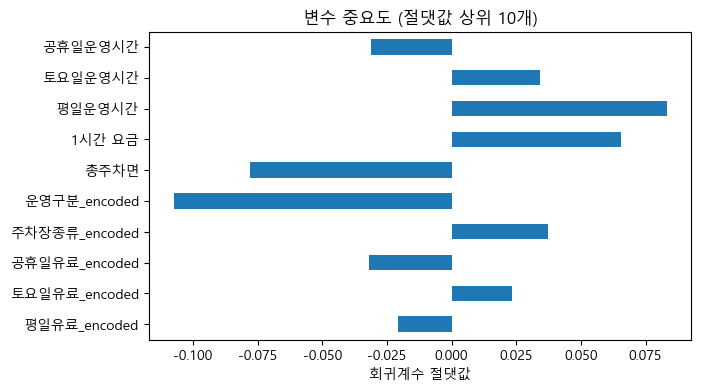

In [315]:
import pandas as pd
coef = pd.Series(reg.coef_, index=feature_names)

print("=== 변수 중요도 (절댓값 기준 상위 10개) ===")
print(coef.head(10))

# 중요도 barplot 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
coef.head(10).plot(kind='barh')
plt.title("변수 중요도 (절댓값 상위 10개)")
plt.xlabel("회귀계수 절댓값")
plt.show()